# TASK 1: Image reading and displaying

Image reading is a core functionality of any image processing algorithm and often available in the form of a function ‘imread()’. In this task you need to write your own ‘imread()’ function which can read .pgm images (pgm test dataset is given with this assignment). Once you read your image(s), you need display them with existing library call.

In [57]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import os

import pywt
import pywt.data
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

from sklearn.metrics import mean_squared_error
from math import sqrt

In [58]:
def show_image_greyscale(image_matrix):
    """
    show_image_greyscale
    shows image in greyscale

    Input: matrix of image pixels
    Output: shows image
    """
    plt.imshow(image_matrix, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.margins(x=0)
    plt.show()

def read_pgm(im):
    """
    read_pgm reads pgm file and return the matrix store image data
    input: pgm file
    output: image matrix
    """
    with open(im, 'rb') as f:
        metadata = f.readline().decode("utf-8").rstrip('\n').split(" ")
        if len(metadata) == 1: # Read for more metadata in other line
            # Format
            format = metadata[0]
            
            # Check comment
            next_line = f.readline().decode("utf-8").rstrip('\n')
            while next_line.startswith('#'):
                next_line = f.readline().decode("utf-8").rstrip('\n')
            
            # Check Dimension
            shape = next_line.split(" ")
            num_rows = int(shape[1])
            num_columns = int(shape[0])

            # Get maximum grey level specify in the image
            max_grey_level = int(f.readline().decode("utf-8").rstrip('\n'))
        else: 
            format, num_columns, num_rows, max_grey_level = metadata[0], int(metadata[1]), int(metadata[2]), int(metadata[3])
        
        # Read pixel data
        pixel_data = f.read()
        if format == 'P2':
            # Decode byte to string to get the raster
            decoded_string = pixel_data.decode("utf-8")
            pgm_info = [int(data.strip("\n")) for data in decoded_string.split(" ") if data.strip("\n")]

            # Convert the list to a NumPy array and reshape
            pic = np.array(pgm_info, dtype=int).reshape(num_rows, num_columns) 
        
        elif format == 'P5':
            # Convert binary data to ASCII
            pixels = [byte for byte in pixel_data]
            pic = np.array(pixels, dtype=int).reshape(num_rows, num_columns)
        
        else:
            raise("Unknown format")

    # Normalize to the range [0, 1]
    normalized_image = pic / max_grey_level

    return normalized_image 

### Test read image

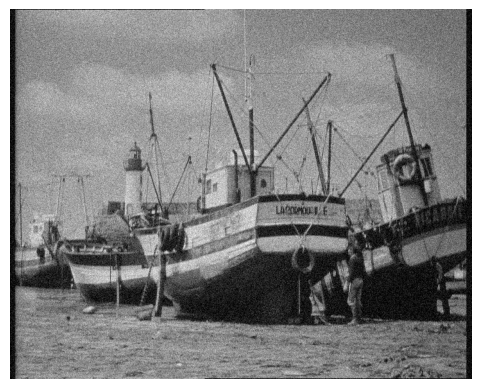

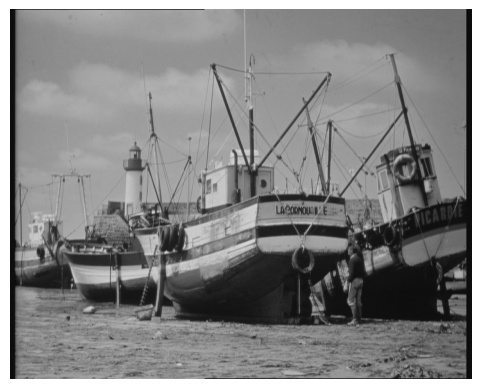

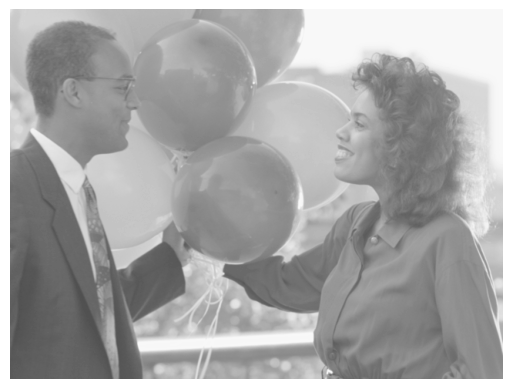

In [59]:
pgm_p5_oneline = "./Noisy/noisy_1/boats.pgm"
pgm_p5 = "./Dataset/boats.pgm"
pgm_p2 = "example.ascii.pgm"

show_image_greyscale(read_pgm(pgm_p5_oneline))
show_image_greyscale(read_pgm(pgm_p5))
show_image_greyscale(read_pgm(pgm_p2))

# TASK 2: Wavelet Decomposition
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

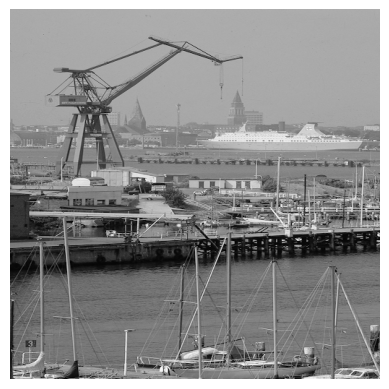

In [60]:
# Load image
im = read_pgm("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [93]:
# Image Utility function
def show_images_4_grids(LL, LH, HL, HH, level, wording="Wavelet transformation Level"):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"{wording} {level}")
    plt.show()

In [62]:
a = np.arange(0,12).reshape(3,4)
replicate_right_and_bottom_padding(a)

array([[ 0,  1,  2,  3,  3],
       [ 4,  5,  6,  7,  7],
       [ 8,  9, 10, 11, 11],
       [ 8,  9, 10, 11, 11]])

## Forward and Inverse Wavelet Transform

In [63]:
def downsample_cols(matrix):
    """
    Input: 2D array
    Output: return 2D array with only the even columns in the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6]])

    Output: array([[1, 3],
                   [4, 6]])
    """
    return matrix[:, ::2]

def downsample_rows(matrix):
    """
    Input: 2D array
    Output: return 2D array with only the even rows in the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
                  
    Output: array([[1, 2, 3],
                   [7, 8, 9]])
    """
    return matrix[::2, :]

def upsample_rows(matrix):
    """
    Input: 2D array
    Output: return 2D arrays with rows of zeroes inserting on top, between, and bottom of the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
                  
    Output: array([[0., 0., 0.],
                   [1., 2., 3.],
                   [0., 0., 0.],
                   [4., 5., 6.],
                   [0., 0., 0.],
                   [7., 8., 9.],
                   [0., 0., 0.]])
    """
    rows, cols = matrix.shape
    upsampled = np.zeros(((2 * rows) + 1, cols))
    upsampled[1::2, :] = matrix  # Put matrix values in odd indices (1,3,5...)
    return upsampled


def upsample_cols(matrix):
    """
    Input: 2D array
    Output: return 2D arrays with columns of 0 inserting on left-most, right-most, and between the input matrix

    Example
    Input: array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
                  
    Output: array([[0., 0., 0.],
                   [1., 2., 3.],
                   [0., 0., 0.],
                   [4., 5., 6.],
                   [0., 0., 0.],
                   [7., 8., 9.],
                   [0., 0., 0.]])
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, (2 * cols) + 1))
    upsampled[:, 1::2] = matrix

    return upsampled

def convolve_by_column(m, filter):
    """
    Input: 1) matrix 2) filter
    Output: The convolution of filter along each column of the matrix stride by 1
    """
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)

    return result

def convolve_by_row(m, filter):
    """
    Input: 1) matrix 2) filter
    Output: The convolution of filter along each row of the matrix stride by 1
    """
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    return result


def replicate_right_and_bottom_padding(arr):
    """
    Input: 2D array
    Output: 2D array with duplicate right most column and last row
    """
    replicate_all_edges = np.pad(arr, pad_width=1, mode='edge')
    remove_left_and_top_padding = replicate_all_edges[1:, 1:]

    return remove_left_and_top_padding 

def add_frequency(a, b):
    """
    Input: two 2D arrays
    Output: added input arrays. In case, the input shape do not match each other, the bigger input will be cropped to match the smaller one
    """
    if a.shape == b.shape:
        return a + b
    
    diff_in_rows = a.shape[0] - b.shape[0]
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    return a+b

In [64]:
def forward_wavelet_transform(im):
    """
    Input: 2D array image
    Output: Forward wavelet transform with haar coefficient on the input
    """
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)

    padded_image = replicate_right_and_bottom_padding(im)

    L = downsample_cols(convolve_by_row(padded_image, low_pass_filter))
    H = downsample_cols(convolve_by_row(padded_image, high_pass_filter))

    LL = downsample_rows(convolve_by_column(L, low_pass_filter))
    LH = downsample_rows(convolve_by_column(L, high_pass_filter))
    HL = downsample_rows(convolve_by_column(H, low_pass_filter))
    HH = downsample_rows(convolve_by_column(H, high_pass_filter))

    return LL, LH, HL, HH

def inverse_wavelet_transform(LL, LH, HL, HH):
    """
    Input: sub-bands of the transformation
    Output: inverse the sub-bands to reconstruct the image
    """
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([-1, 1]) / np.sqrt(2)

    reverse_LL = convolve_by_column(upsample_rows(LL), low_pass_filter)
    reverse_LH = convolve_by_column(upsample_rows(LH), high_pass_filter)
    reconstructed_L = add_frequency(reverse_LH, reverse_LL)

    reverse_HL = convolve_by_column(upsample_rows(HL), low_pass_filter)
    reverse_HH = convolve_by_column(upsample_rows(HH), high_pass_filter)
    reconstructed_H = add_frequency(reverse_HH, reverse_HL)

    reconstructed_image = convolve_by_row(upsample_cols(reconstructed_L), low_pass_filter) + convolve_by_row(upsample_cols(reconstructed_H), high_pass_filter)

    LL_rows = LL.shape[0]
    LL_cols = LL.shape[1]

    if LL_rows % 2 == 0:
        original_rows = LL_rows*2
    else:
        original_rows = ((LL_rows - 1)*2) + 1
    
    if LL_cols % 2 == 0:
        original_cols = LL_cols*2
    else:
        original_cols = ((LL_cols - 1)*2) + 1

    return reconstructed_image[:original_rows, :original_cols]

In [100]:
def forward_wavelet_transform_with_level(image, level, show_image=False):
    """
    Input:
      1) Image - to do the wavelet transform
      2) Level - level of transformation
      3) Show image - boolean value on whether to show image or not
    Output: the sub-bands for each level transform
    """
    result = []
    for l in range(1, level+1):
        LL, LH, HL, HH = forward_wavelet_transform(image)
        image = LL
        if show_image:
            show_images_4_grids(LL, LH, HL, HH, l)
        
        result.append(
            {
                "LL": LL, 
                "LH": LH, 
                "HL": HL, 
                "HH": HH
            }
        )
    
    return result

def inverse_wavelet_transform_many_levels(res, show_image=False):
    """
    Construct the image starting from the last_level to get LL of last_level-1, 
    then repeat the step until finally reached the reconstructed original image

    Input: result of each level sub-bands
    Output: the reconsturcted image from sub-bands
    """
    level = len(res)
    reconstructed_im = None
    
    for l in range(level-1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        if show_image:
            show_images_4_grids(LL, LH, HL, HH, l+1, wording="Inverse wavelet transform level")
        
        reconstructed_im = inverse_wavelet_transform(LL, LH, HL, HH)

    return reconstructed_im
        

## Calculate MSE

In [66]:
def calculate_mse(original_image, reconstructed_image):
    """
    Input:
      1) Original Image
      2) Reconstructed Image
    Output: Mean square error of the original and reconstructed image
    """
    num_rows, num_cols = original_image.shape
    reconstructed_image = reconstructed_image[:num_rows, :num_cols]

    return mean_squared_error(original_image, reconstructed_image)

## Test Wavelet forward transform 3 level

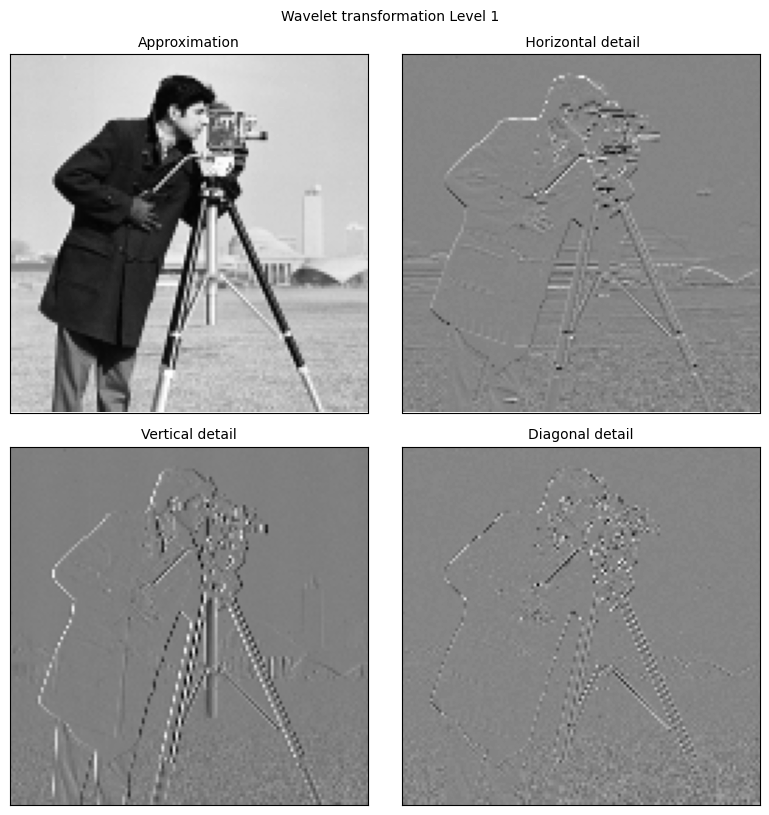

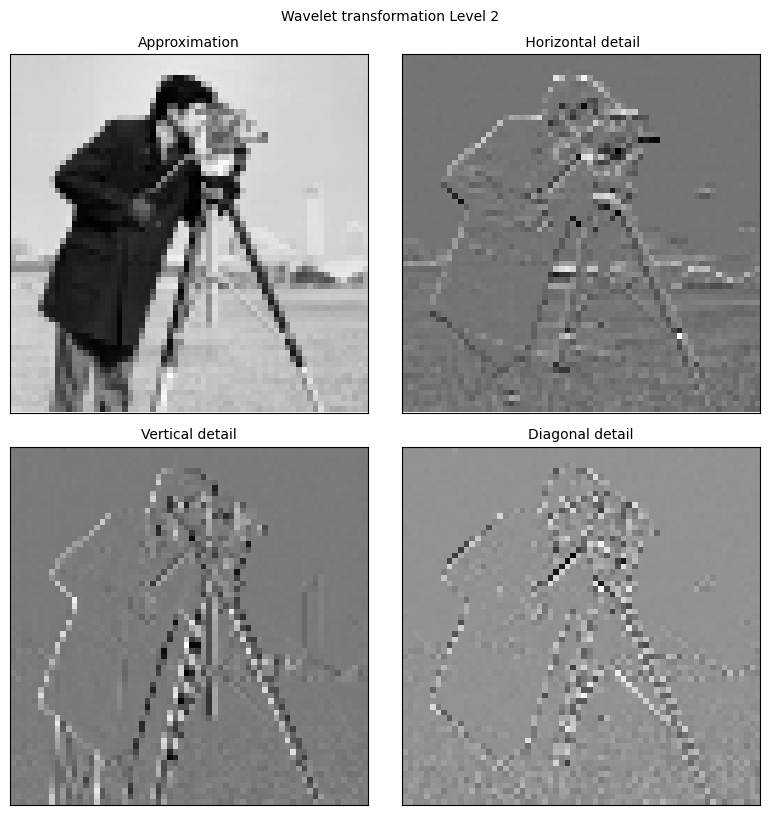

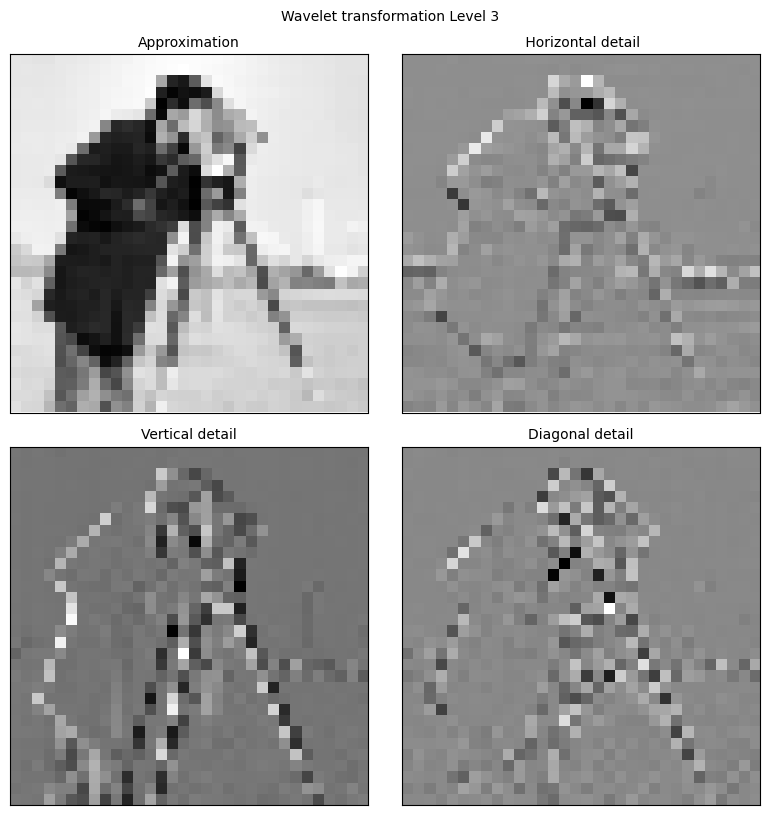

In [95]:
camera_man_image = read_pgm("./Dataset/cameraman.pgm")

level = 3
show_result = True
res = forward_wavelet_transform_with_level(camera_man_image, level, show_result)

## Test inverse transform

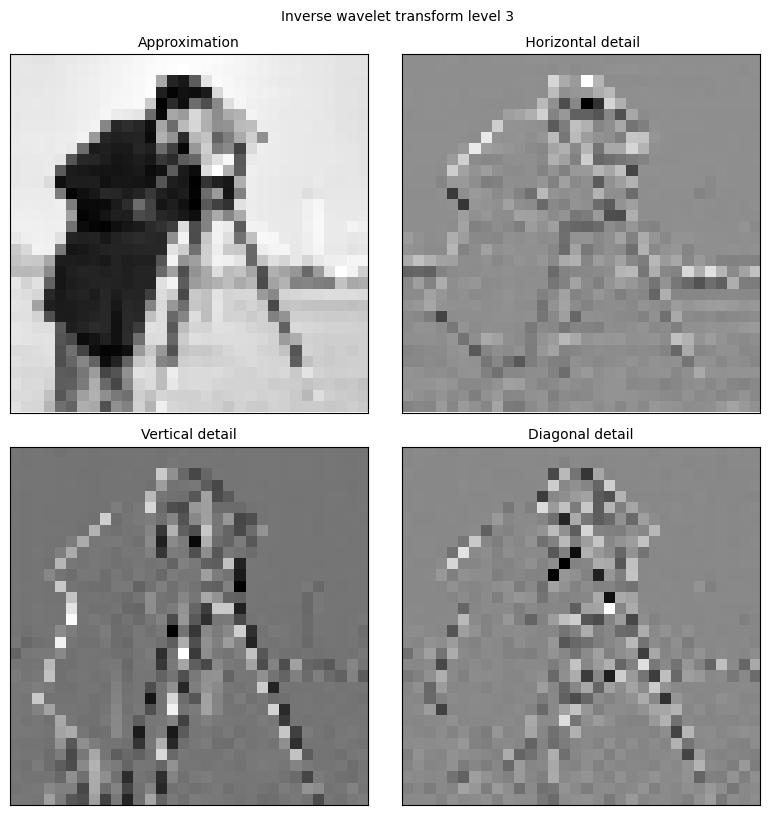

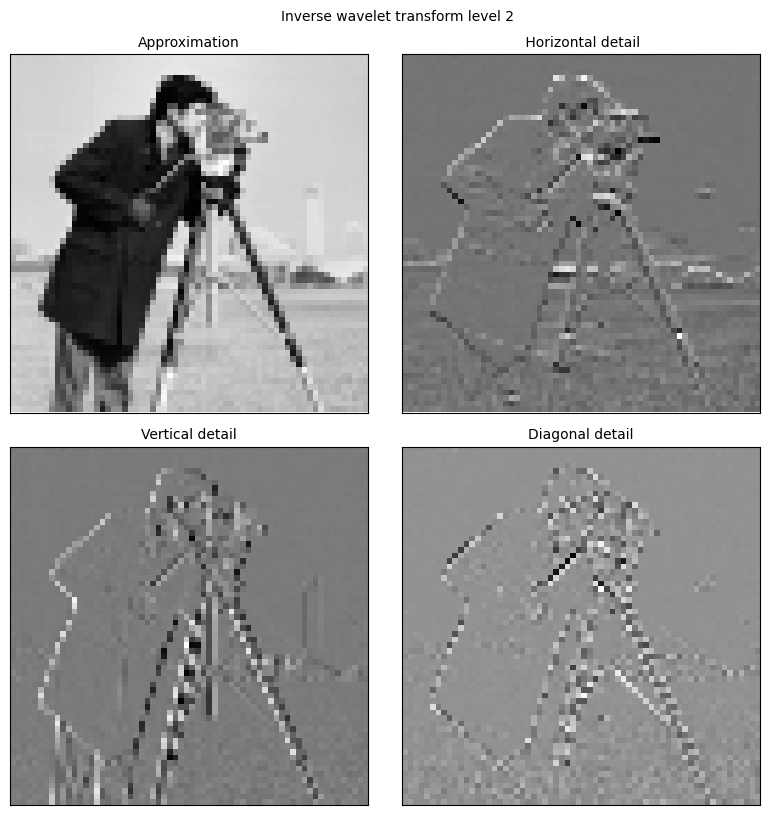

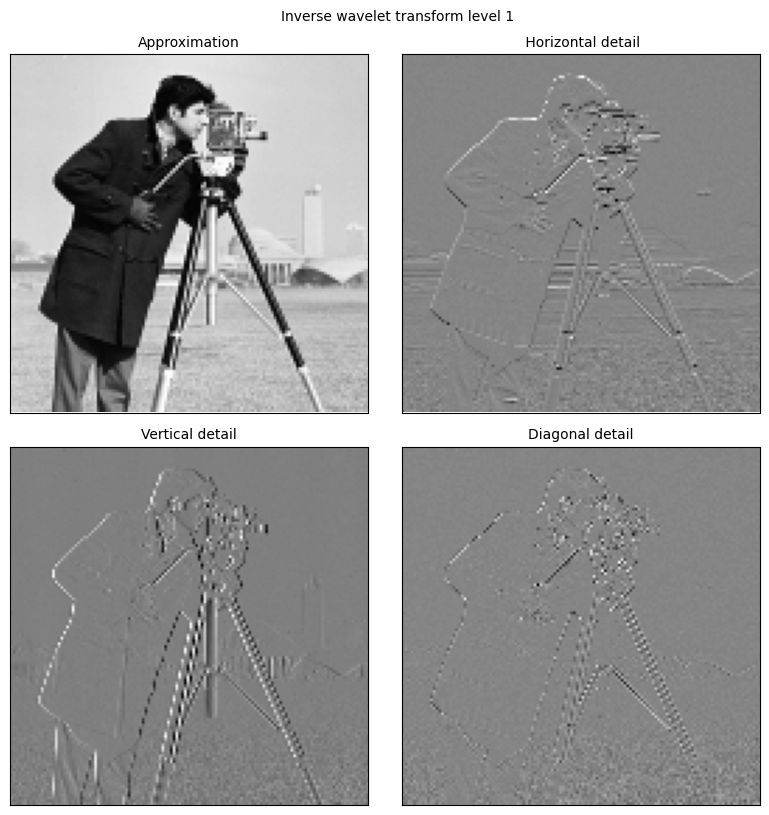

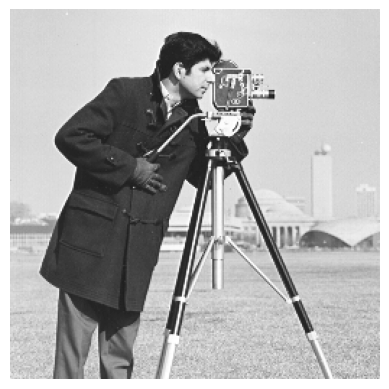

In [101]:
reconstructed_image = inverse_wavelet_transform_many_levels(res, True)
show_image_greyscale(reconstructed_image)

In [69]:
camera_man_mse = calculate_mse(camera_man_image, reconstructed_image)
camera_man_mse

np.float64(5.793455587600399e-31)

## Test calculate MSE

In [70]:
# Run all image

dataset_directory = './Dataset'
for filename in os.listdir(dataset_directory):
    if filename.endswith(".pgm"):
        file_with_directory = dataset_directory + "/" + filename
        print(file_with_directory)
        im = read_pgm(file_with_directory)

        res = forward_wavelet_transform_with_level(im, 3, False)
        reconstructed_image = inverse_wavelet_transform_many_levels(res)
        mse = calculate_mse(im, reconstructed_image)

        print(f"MSE = {mse}")

./Dataset/man.pgm
MSE = 2.0229964374530204e-31
./Dataset/lungs.pgm
MSE = 6.8569877786461525e-31
./Dataset/clown.pgm
MSE = 1.5556811011268754e-31
./Dataset/clock.pgm
MSE = 6.846055941950291e-31
./Dataset/kiel.pgm
MSE = 3.351491319970985e-31
./Dataset/zelda2.pgm
MSE = 2.4632677549802073e-31
./Dataset/dogbone.pgm
MSE = 1.9252693342154976e-31
./Dataset/truck.pgm
MSE = 2.2125831835131285e-31
./Dataset/couple.pgm
MSE = 2.9873874157689402e-31
./Dataset/mandrill.pgm
MSE = 3.2809291665688787e-31
./Dataset/boats.pgm
MSE = 3.008061710276942e-31
./Dataset/cameraman.pgm
MSE = 5.793455587600399e-31
./Dataset/crowd.pgm
MSE = 1.6853167714483535e-31
./Dataset/girlface.pgm
MSE = 1.7092478123166722e-31
./Dataset/houses.pgm
MSE = 3.6178168816150564e-31
./Dataset/Brain1.pgm
MSE = 1.940750473774708e-31
./Dataset/barbara.pgm
MSE = 2.9844807539967466e-31
./Dataset/lighthouse.pgm
MSE = 2.8936035433332422e-31
./Dataset/bridge.pgm
MSE = 2.810520183684701e-31


# Task 3: Denoise

## Original Image

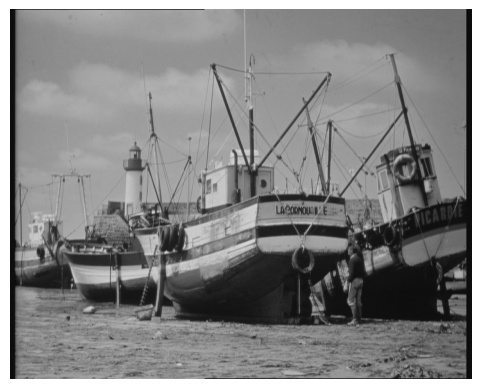

In [200]:
file = './Dataset/boats.pgm'
original_im = read_pgm(file)

show_image_greyscale(original_im)

## Noisy Image

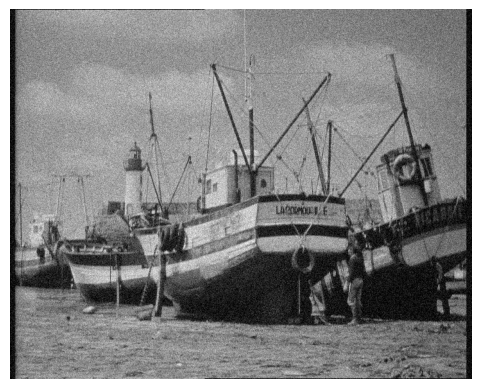

In [209]:
file = './Noisy/noisy_1/boats.pgm'
noisy_image_1 = read_pgm(file)

show_image_greyscale(noisy_image_1)

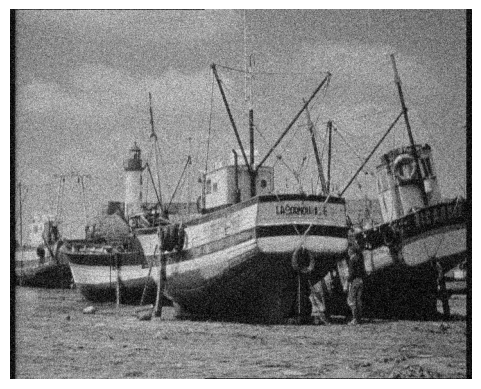

In [210]:
file = './Noisy/noisy_2/boats.pgm'
noisy_image_2 = read_pgm(file)

show_image_greyscale(noisy_image_2)

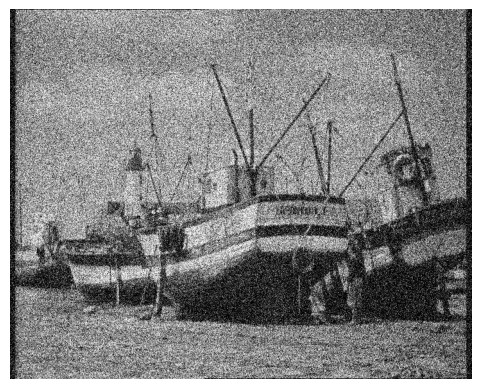

In [211]:
file = './Noisy/noisy_3/boats.pgm'
noisy_image_3 = read_pgm(file)

show_image_greyscale(noisy_image_3)

## Develop denoise algorithm

### Step 1: Wavelet decomposition
Perform the 3th decompositions on 2-D discrete wavelet transform (DWT) for a noisy image f to get noisy wavelet coefficients F.

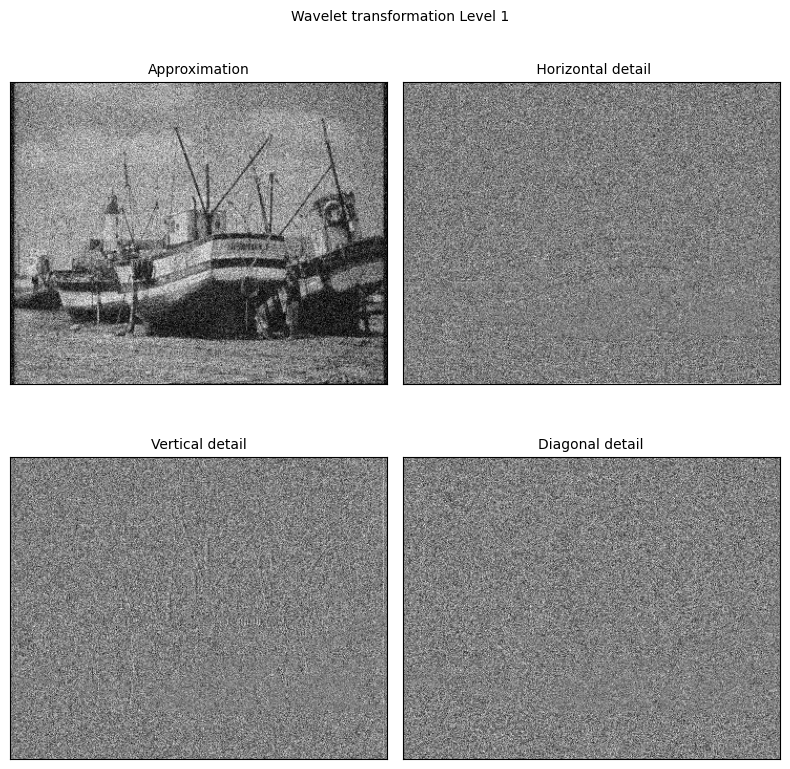

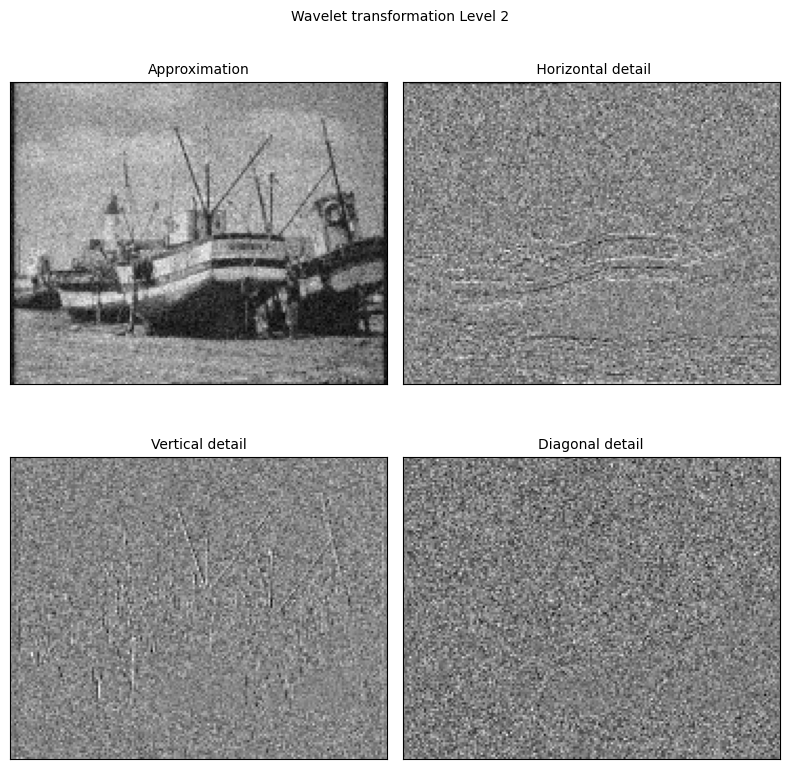

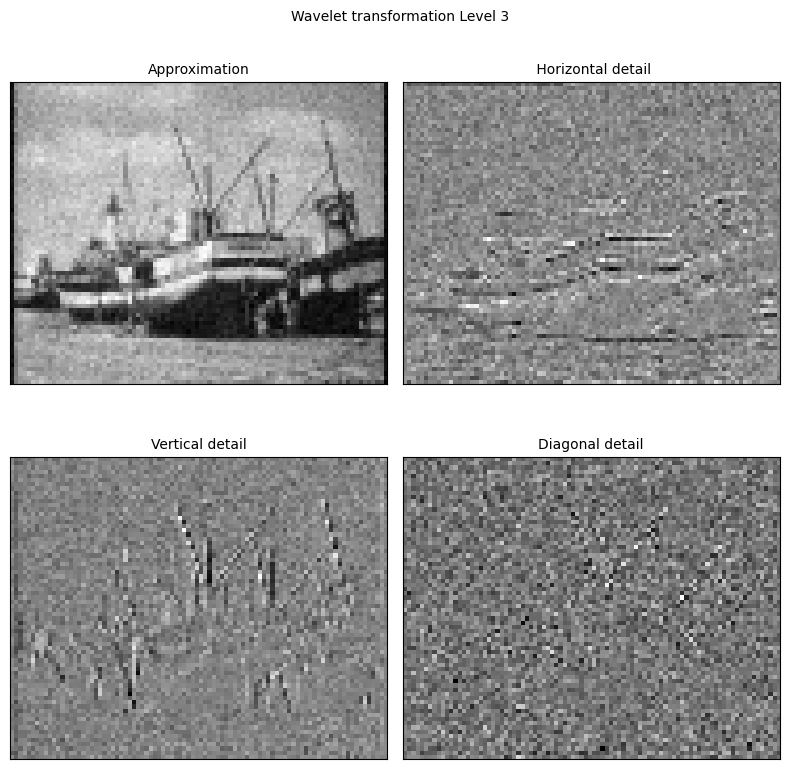

In [122]:
res = forward_wavelet_transform_with_level(noisy_image_3, 3, show_image=True)
dwt_level_1 = res[0]
dwt_level_2 = res[1]
dwt_level_3 = res[2]

### Step 2: Calculate the noise variance from HH1 subband
Estimate the noise variance

In [143]:
def get_noise_variance(HH):
   return (np.median(np.abs(HH)/ 0.06745)) ** 2

noise_variance = get_noise_variance(dwt_level_1['HH'])

### Step 3: Calculate the threshold TNew at each high subband

In [223]:
from math import sqrt, log, e
# Calculate function G
def sum_wavelet_coefficient_on_subband(F):
    return np.sum(F)

# Calculate function S
def threshold_factor_S(G_LH, G_HL, G_HH, level_decomposition, image_size):
    return sum([G_LH, G_HL, G_HH])/ (image_size/ 2**level_decomposition)

# Calculate original threshold
def original_threshold(noise_variance, image_size):
    return sqrt(noise_variance) * sqrt(2 * log (image_size))

# Calculate function P
def threshold_factor_P(T, S):
    return e ** ((T-S)/ (T+S))

# Calculate t_new
def threshold_with_new_method(noise_variance, p):
    return sqrt(noise_variance) * p 


In [131]:
function_s

6

In [129]:
G_LH = sum_wavelet_coefficient_on_subband(dwt_level_3['LH']) # Horizontal
G_HL = sum_wavelet_coefficient_on_subband(dwt_level_3['HL']) # Vertical
G_HH = sum_wavelet_coefficient_on_subband(dwt_level_3['HH']) # Diagonal

print(f"G_LH: {G_LH}")
print(f"G_HL: {G_HL}")
print(f"G_HH: {G_HH}")

G_LH: -9.501960784313752
G_HL: -32.29019607843134
G_HH: 10.988235294117633


In [157]:
s = threshold_factor_S(G_LH, G_HL, G_HH, 3, noisy_image_3.shape[0])
t = original_threshold(noise_variance, noisy_image_3.shape[0])
p = threshold_factor_P(t,s)
t_new = threshold_with_new_method(noise_variance, p)
t_new

np.float64(6.347684793681103)

## Gemini

In [204]:
from math import sqrt, log, e
import numpy as np

def get_noise_variance(HH_coefficients):
    median_abs = np.median(np.abs(HH_coefficients))
    return (median_abs / 0.06745) ** 2

def sum_wavelet_coefficient_on_subband(F):
    return np.sum(F)

def original_threshold(noise_variance, image_size):
    return sqrt(noise_variance) * sqrt(2 * log (image_size))

def threshold_factor_S(G, level_decomposition, image_size):
    return G / (image_size/ 2**level_decomposition)

def threshold_factor_P(T, S):
    return e ** ((T-S)/ (T+S))

def threshold_with_new_method(noise_variance, p):
    return sqrt(noise_variance) * p

def apply_soft_threshold(f, t):
    if f >= t:
        return f - t
    elif f <= -t:
        return f + t
    else:
        return 0

def apply_soft_threshold_to_array(array, threshold):
    return np.vectorize(lambda f: apply_soft_threshold(f, threshold))(array)

def applied_soft_threshold_to_high_subband(LH, HL, HH, decomposition_level, image_width, noise_variance):
    G_LH = sum_wavelet_coefficient_on_subband(LH) 
    G_HL = sum_wavelet_coefficient_on_subband(HL) 
    G_HH = sum_wavelet_coefficient_on_subband(HH)

    # Calculate S for each subband
    S_LH = threshold_factor_S(G_LH, decomposition_level, image_width)
    S_HL = threshold_factor_S(G_HL, decomposition_level, image_width)
    S_HH = threshold_factor_S(G_HH, decomposition_level, image_width)

    # Calculate original threshold
    t = original_threshold(noise_variance, image_width)

    # Calculate new thresholds for each subband
    p_LH = threshold_factor_P(t, S_LH)
    p_HL = threshold_factor_P(t, S_HL)
    p_HH = threshold_factor_P(t, S_HH)

    t_new_LH = threshold_with_new_method(noise_variance, p_LH)
    t_new_HL = threshold_with_new_method(noise_variance, p_HL)
    t_new_HH = threshold_with_new_method(noise_variance, p_HH)

    applied_threshold_on_LH = apply_soft_threshold_to_array(LH, t_new_LH)
    applied_threshold_on_HL = apply_soft_threshold_to_array(HL, t_new_HL)
    applied_threshold_on_HH = apply_soft_threshold_to_array(HH, t_new_HH)

    return applied_threshold_on_LH, applied_threshold_on_HL, applied_threshold_on_HH 

In [220]:
def denoised_image_with_3_level_wavelet_decomposition(image_with_noise):
    # Step 1: Forward wavelet transform
    res = forward_wavelet_transform_with_level(image_with_noise, 3)
    dwt_level_1 = res[0]
    dwt_level_2 = res[1]
    dwt_level_3 = res[2]

    # Calculate the noise variance from level 1 HH
    noise_variance_1 = get_noise_variance(dwt_level_1['HH']) 

    # image size
    M = image_with_noise.shape[0]

    # Denoise level 3
    noise_variance_3 = get_noise_variance(dwt_level_3['HH'])
    LH_3, HL_3, HH_3 = applied_soft_threshold_to_high_subband(dwt_level_3['LH'], dwt_level_3['HL'], dwt_level_3['HH'], 3, M, noise_variance_1)
    denoise_level3_inverse = inverse_wavelet_transform(dwt_level_3['LL'],  LH_3, HL_3, HH_3)

    # Denoise level 2
    noise_variance_2 = get_noise_variance(dwt_level_2['HH'])
    LH_2, HL_2, HH_2 = applied_soft_threshold_to_high_subband(dwt_level_2['LH'], dwt_level_2['HL'], dwt_level_2['HH'], 2, M, noise_variance_1)
    denoise_level2_inverse = inverse_wavelet_transform(denoise_level3_inverse,  LH_2, HL_2, HH_2)

    # Denoise level 1
    noise_variance_1 = get_noise_variance(dwt_level_1['HH'])
    LH_1, HL_1, HH_1 = applied_soft_threshold_to_high_subband(dwt_level_1['LH'], dwt_level_1['HL'], dwt_level_1['HH'], 1, M, noise_variance_1)
    denoise_level1_inverse = inverse_wavelet_transform(denoise_level2_inverse,  LH_1, HL_1, HH_1)

    return denoise_level1_inverse

In [221]:
denoise_im_1 = denoised_image_with_3_level_wavelet_decomposition(noisy_image_1)
# denoise_im_2 = denoised_image_with_3_level_wavelet_decomposition(noisy_image_2)
# denoise_im_3 = denoised_image_with_3_level_wavelet_decomposition(noisy_image_3)

Image 1
Before


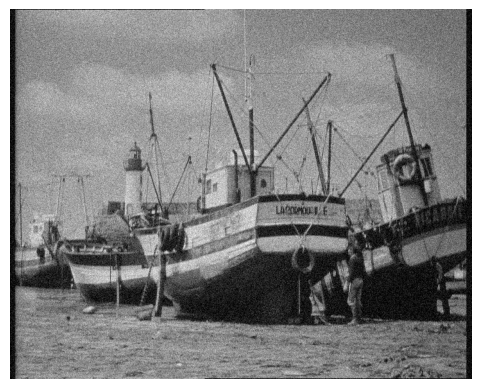

After


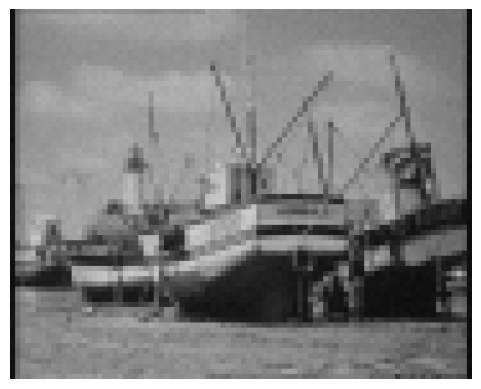

-----------------


In [222]:
print("Image 1")
print("Before")
show_image_greyscale(noisy_image_1)
print("After")
show_image_greyscale(denoise_im_1)
print("-----------------")

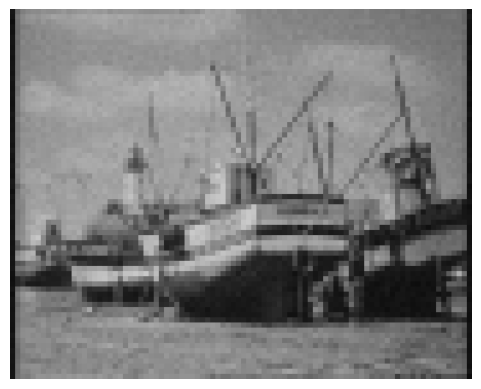

In [214]:
show_image_greyscale(denoise_im_2)

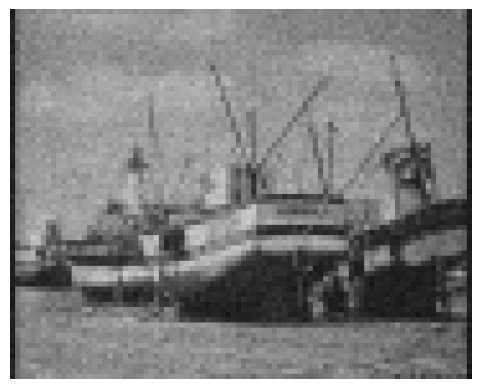

In [215]:
show_image_greyscale(denoise_im_3)

In [ ]:
# Level 3
# Calculate G for each subband
G_LH = sum_wavelet_coefficient_on_subband(dwt_level_3['LH']) 
G_HL = sum_wavelet_coefficient_on_subband(dwt_level_3['HL']) 
G_HH = sum_wavelet_coefficient_on_subband(dwt_level_3['HH'])

# Calculate S for each subband
S_LH = threshold_factor_S(G_LH, 3, noisy_image_3.shape[0])
S_HL = threshold_factor_S(G_HL, 3, noisy_image_3.shape[0])
S_HH = threshold_factor_S(G_HH, 3, noisy_image_3.shape[0])

# Calculate original threshold
t = original_threshold(noise_variance, noisy_image_3.shape[0])

# Calculate new thresholds for each subband
p_LH = threshold_factor_P(t, S_LH)
p_HL = threshold_factor_P(t, S_HL)
p_HH = threshold_factor_P(t, S_HH)

t_new_LH = threshold_with_new_method(noise_variance, p_LH)
t_new_HL = threshold_with_new_method(noise_variance, p_HL)
t_new_HH = threshold_with_new_method(noise_variance, p_HH)

applied_threshold_on_LH = apply_soft_threshold_to_array(dwt_level_3['LH'], t_new_LH)
applied_threshold_on_HL = apply_soft_threshold_to_array(dwt_level_3['HL'], t_new_HL)
applied_threshold_on_HH = apply_soft_threshold_to_array(dwt_level_3['HH'], t_new_HH)

denoise_level3_inverse = inverse_wavelet_transform(dwt_level_3['LL'], applied_threshold_on_LH, applied_threshold_on_HL, applied_threshold_on_HH)

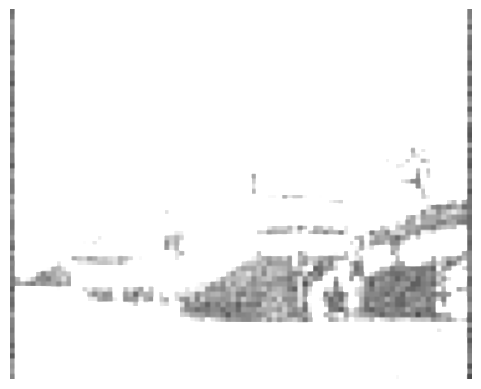

In [189]:
show_image_greyscale(denoise_level3_inverse)

#### Level 2

In [194]:
G_LH = sum_wavelet_coefficient_on_subband(dwt_level_2['LH']) 
G_HL = sum_wavelet_coefficient_on_subband(dwt_level_2['HL']) 
G_HH = sum_wavelet_coefficient_on_subband(dwt_level_2['HH'])

# Calculate S for each subband
S_LH = threshold_factor_S(G_LH, 2, noisy_image_3.shape[0])
S_HL = threshold_factor_S(G_HL, 2, noisy_image_3.shape[0])
S_HH = threshold_factor_S(G_HH, 2, noisy_image_3.shape[0])

# Calculate original threshold
t = original_threshold(noise_variance, noisy_image_3.shape[0])

# Calculate new thresholds for each subband
p_LH = threshold_factor_P(t, S_LH)
p_HL = threshold_factor_P(t, S_HL)
p_HH = threshold_factor_P(t, S_HH)

t_new_LH = threshold_with_new_method(noise_variance, p_LH)
t_new_HL = threshold_with_new_method(noise_variance, p_HL)
t_new_HH = threshold_with_new_method(noise_variance, p_HH)

applied_threshold_on_LH = apply_soft_threshold_to_array(dwt_level_2['LH'], t_new_LH)
applied_threshold_on_HL = apply_soft_threshold_to_array(dwt_level_2['HL'], t_new_HL)
applied_threshold_on_HH = apply_soft_threshold_to_array(dwt_level_2['HH'], t_new_HH)

denoise_level2_inverse = inverse_wavelet_transform(denoise_level3_inverse, applied_threshold_on_LH, applied_threshold_on_HL, applied_threshold_on_HH)

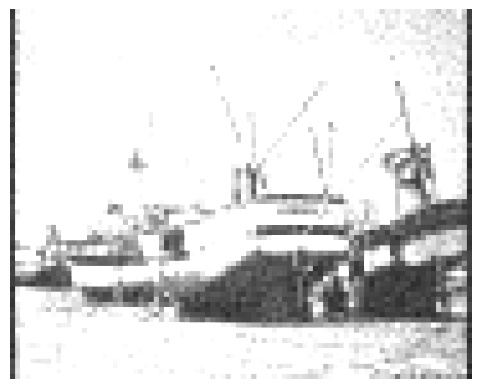

In [191]:
show_image_greyscale(denoise_level2_inverse)

#### Level 1

In [195]:
G_LH = sum_wavelet_coefficient_on_subband(dwt_level_1['LH']) 
G_HL = sum_wavelet_coefficient_on_subband(dwt_level_1['HL']) 
G_HH = sum_wavelet_coefficient_on_subband(dwt_level_1['HH'])

# Calculate S for each subband
S_LH = threshold_factor_S(G_LH, 1, noisy_image_3.shape[0])
S_HL = threshold_factor_S(G_HL, 1, noisy_image_3.shape[0])
S_HH = threshold_factor_S(G_HH, 1, noisy_image_3.shape[0])

# Calculate original threshold
t = original_threshold(noise_variance, noisy_image_3.shape[0])

# Calculate new thresholds for each subband
p_LH = threshold_factor_P(t, S_LH)
p_HL = threshold_factor_P(t, S_HL)
p_HH = threshold_factor_P(t, S_HH)

t_new_LH = threshold_with_new_method(noise_variance, p_LH)
t_new_HL = threshold_with_new_method(noise_variance, p_HL)
t_new_HH = threshold_with_new_method(noise_variance, p_HH)

applied_threshold_on_LH = apply_soft_threshold_to_array(dwt_level_1['LH'], t_new_LH)
applied_threshold_on_HL = apply_soft_threshold_to_array(dwt_level_1['HL'], t_new_HL)
applied_threshold_on_HH = apply_soft_threshold_to_array(dwt_level_1['HH'], t_new_HH)

denoise_level1_inverse = inverse_wavelet_transform(denoise_level2_inverse, applied_threshold_on_LH, applied_threshold_on_HL, applied_threshold_on_HH)

In [201]:
from skimage.metrics import peak_signal_noise_ratio
psnr = peak_signal_noise_ratio(original_im, denoise_level1_inverse)
psnr

np.float64(22.344645815794372)

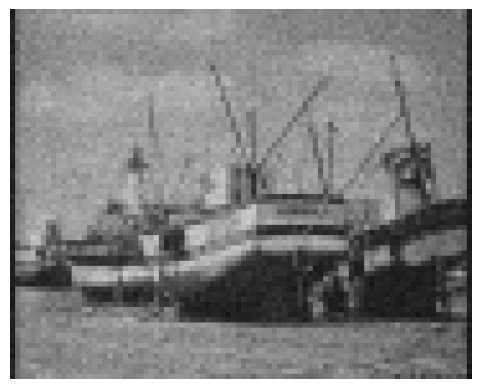

In [196]:
show_image_greyscale(denoise_level1_inverse)

In [ ]:
## Normal Inverse
level3_inverse = inverse_wavelet_transform(dwt_level_3['LL'], dwt_level_3['LH'], dwt_level_3['HL'], dwt_level_3['HH'])
level2_inverse = inverse_wavelet_transform(level3_inverse, dwt_level_2['LH'], dwt_level_2['HL'], dwt_level_2['HH'])
level1_inverse = inverse_wavelet_transform(level2_inverse, dwt_level_1['LH'], dwt_level_1['HL'], dwt_level_1['HH'])

In [179]:
## Denoise inverse


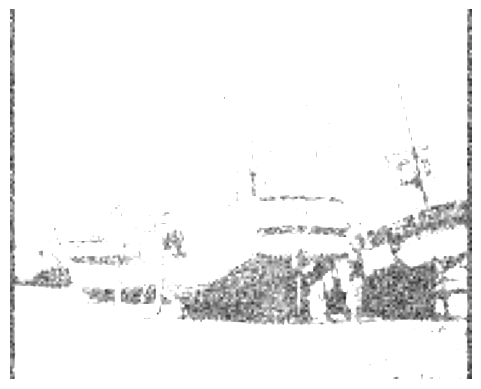

In [178]:
show_image_greyscale(level3_inverse)

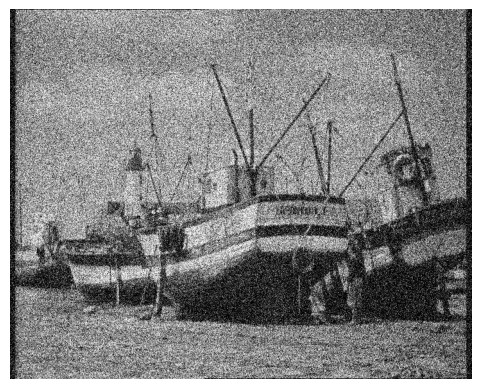

In [197]:
show_image_greyscale(level1_inverse)

## Denoise Image using library

In [ ]:
import matplotlib.pyplot as plt

from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

### Mean filter

### Median filter

### BayesShrink - Wavelet Denoising using function call

In [ ]:
im_bayes_1 = denoise_wavelet(
    im1,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
)
im_bayes_2 = denoise_wavelet(
    im2,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
)
im_bayes_3 = denoise_wavelet(
    im3,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
)

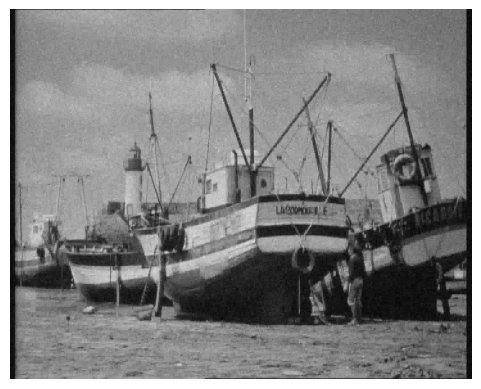

In [ ]:
show_image_greyscale(im_bayes_1)

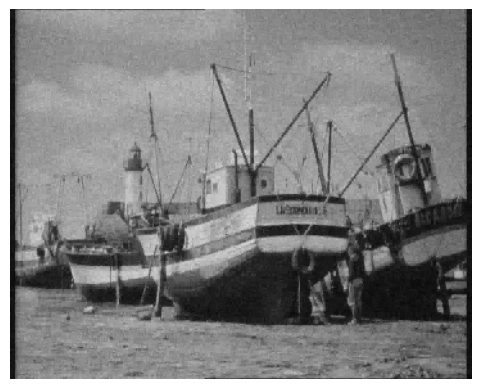

In [ ]:
show_image_greyscale(im_bayes_2)

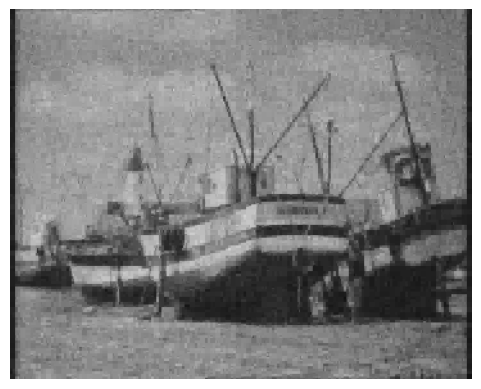

In [ ]:
show_image_greyscale(im_bayes_3)

### VisuShrink - Wavelet Denoising using function call

Estimated Gaussian noise standard deviation = 0.07188690519080122
Estimated Gaussian noise standard deviation = 0.09943036497645408
Estimated Gaussian noise standard deviation = 0.20949478966259258


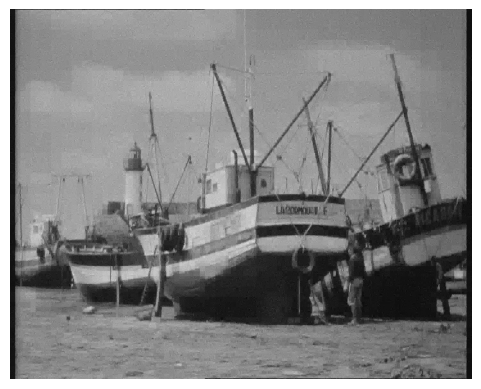

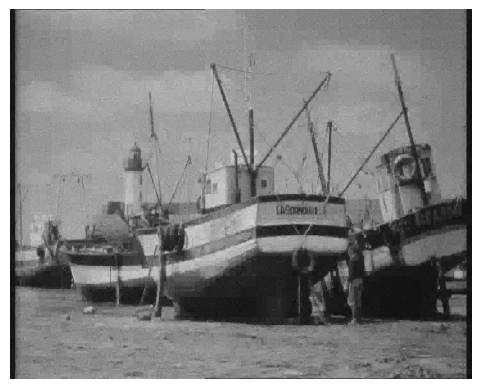

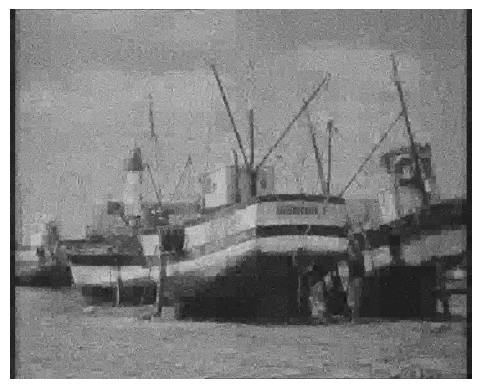

In [ ]:
# Estimate the average noise standard deviation across color channels.
sigma_est_1 = estimate_sigma(im1, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est_1}')

# Estimate the average noise standard deviation across color channels.
sigma_est_2 = estimate_sigma(im2, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est_2}')

# Estimate the average noise standard deviation across color channels.
sigma_est_3 = estimate_sigma(im3, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est_3}')

im_visushrink_1 = denoise_wavelet(
    im1,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est_1/4,
    rescale_sigma=True,
)

im_visushrink_2 = denoise_wavelet(
    im2,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est_2/4,
    rescale_sigma=True,
)

im_visushrink_3 = denoise_wavelet(
    im3,
    method='VisuShrink',
    mode='soft',
    sigma=sigma_est_3/4,
    rescale_sigma=True,
)



show_image_greyscale(im_visushrink_1)
show_image_greyscale(im_visushrink_2)
show_image_greyscale(im_visushrink_3)

## Compare the result

### PSNR

Compare the result using PSNR (Peak Signal to Noise Ratio)
- The higher the value is the better the image

In [ ]:
print("==== PSNR - Original ====")
psnr_noisy_1 = peak_signal_noise_ratio(original_im, im1)
print(f"im1 = {psnr_noisy_1}")

psnr_noisy_2 = peak_signal_noise_ratio(original_im, im2)
print(f"im2 = {psnr_noisy_2}")

psnr_noisy_3 = peak_signal_noise_ratio(original_im, im3)
print(f"im3 = {psnr_noisy_3}")

print("==== PSNR - Reduce noise by BayesShrink ====")
psnr_noisy_1_bayes = peak_signal_noise_ratio(original_im, im_bayes_1)
print(f"im1 = {psnr_noisy_1_bayes}")

psnr_noisy_2_bayes = peak_signal_noise_ratio(original_im, im_bayes_2)
print(f"im2 = {psnr_noisy_2_bayes}")

psnr_noisy_3_bayes = peak_signal_noise_ratio(original_im, im_bayes_3)
print(f"im3 = {psnr_noisy_3_bayes}")

print("==== PSNR - Reduce noise by VisuShrink/4 ====")
psnr_noisy_1_visu = peak_signal_noise_ratio(original_im, im_visushrink_1)
print(f"im1 = {psnr_noisy_1_visu}")

psnr_noisy_2_visu = peak_signal_noise_ratio(original_im, im_visushrink_2)
print(f"im2 = {psnr_noisy_2_visu}")

psnr_noisy_3_visu = peak_signal_noise_ratio(original_im, im_visushrink_3)
print(f"im3 = {psnr_noisy_3_visu}")

==== PSNR - Original ====
im1 = 23.129958591252887
im2 = 20.20032212360011
im3 = 13.64196475997476
==== PSNR - Reduce noise by BayesShrink ====
im1 = 29.152835211391285
im2 = 27.43700037998863
im3 = 23.81085024064083
==== PSNR - Reduce noise by VisuShrink/4 ====
im1 = 28.5396116751551
im2 = 26.543289284412705
im3 = 21.569186799062713


### MSE

## Finding the threshold

### Step 1: Doing the wavelet decomposition

### Step 2: Calculate the noise variance from HH subband

In [ ]:
est_noise_variance = (np.median(np.abs(im1))/ 0.06745) ** 2
est_noise_variance

np.float64(60.69673468133016)